# Gradient Boosting Machines (GBMs) with XGBoost

Data used : https://www.kaggle.com/c/rossmann-store-sales/data

Dataset Description

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
Files

- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- sample_submission.csv - a sample submission file in the correct format
- store.csv - supplemental information about the stores

Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store



Problem Statement:

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.

With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.


# IMporting libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# loading data

In [2]:
train_df = pd.read_csv("./data/project1/train.csv", low_memory=False)
store_df = pd.read_csv("./data/project1/store.csv")
test_df = pd.read_csv("./data/project1/test.csv")
submission_df = pd.read_csv("./data/project1/sample_submission.csv")

In [3]:
train_df.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [4]:
store_df.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [5]:
test_df.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


In [6]:
submission_df.head(2)

,Id,Sales
0,1,0
1,2,0


In [7]:
# merge information on store df into train and test df

merged_df_train = train_df.merge(store_df, on='Store', how='left')
merged_df_test = test_df.merge(store_df, on='Store', how='left')

In [8]:
merged_df_train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [9]:
merged_df_test.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## Preprocessing and Feature Engineering

In [10]:
merged_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [11]:
#lets convert data to datetime
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    return df


In [12]:
merged_df_train = split_date(merged_df_train)

In [13]:
merged_df_test = split_date(merged_df_test)

In [14]:
merged_df_test.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,...,9.0,2008.0,0,NaN,NaN,NaN,2015,9,17,38
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38


In [15]:
# Store open/close -- sales zero when shop is closed

print(merged_df_train[merged_df_train['Open'] == 0]['Sales'].values)
merged_df_train[merged_df_train['Open'] == 0]['Sales'].value_counts()


[0 0 0 ... 0 0 0]


Sales
0    172817
Name: count, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [16]:
merged_df_train = merged_df_train[merged_df_train.Open == 1].copy()

In [17]:
#competition
# --Next, we can use the columns CompetitionOpenSince[Month/Year] columns from store_df to compute the number of months for which a competitor has been open near the store.

def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [18]:
comp_months(merged_df_train)
comp_months(merged_df_test)

In [19]:
merged_df_train[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(5)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
957140,2013-02-23,1540.0,NaN,NaN,0.0
9826,2015-07-23,250.0,NaN,NaN,0.0
125262,2015-04-10,350.0,NaN,NaN,0.0
811150,2013-07-04,190.0,NaN,NaN,0.0
854167,2013-05-27,21370.0,2010.0,11.0,30.0


In [20]:
merged_df_train['PromoInterval'].value_counts()

PromoInterval
Jan,Apr,Jul,Oct     242411
Feb,May,Aug,Nov      98005
Mar,Jun,Sept,Dec     80669
Name: count, dtype: int64

In [21]:
# additional promotion
#-->We can also add some additional columns to indicate how long a store has been running Promo2 and whether a new round of Promo2 starts in the current month.

def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    
    try:
        months = (row['PromoTinterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0
    
def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']




In [22]:
promo_cols(merged_df_train)
promo_cols(merged_df_test)

In [23]:
merged_df_train[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(5)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
869382,2013-05-13,0,NaN,NaN,NaN,0.0,0
601783,2014-01-08,0,NaN,NaN,NaN,0.0,0
730952,2013-09-14,0,NaN,NaN,NaN,0.0,0
57765,2015-06-10,0,NaN,NaN,NaN,0.0,0
14784,2015-07-18,0,NaN,NaN,NaN,0.0,0


In [24]:
#Input and Target Columns

In [25]:
merged_df_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [26]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [27]:
inputs = merged_df_train[input_cols].copy()
targets = merged_df_train[target_col].copy()

In [28]:
test_inputs = merged_df_test[input_cols].copy()

In [29]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

In [30]:
#impute missing numerical columns
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [31]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

In [32]:
max_distance = inputs.CompetitionDistance.max()

In [33]:
max_distance

np.float64(75860.0)

In [34]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15960\751725973.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15960\751725973.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [35]:
#scale numerical values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [36]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [37]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [38]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Gradient Boosting

 how a GBM model works:

- The average value of the target column and uses as an initial prediction every input.
- The residuals (difference) of the predictions with the targets are computed.
- A decision tree of limited depth is trained to predict just the residuals for each input.
- Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
- Scaled predictions for the tree are added to the previous predictions to obtain the new and improved predictions.
- |Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model.

In [39]:
from xgboost import XGBRegressor
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)
model.fit(X, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [40]:
preds =model.predict(X)
preds

array([ 8114.2705,  7736.7256,  8129.7466, ...,  7100.061 ,  8884.957 ,
       10913.495 ], dtype=float32)

In [41]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(targets, preds) ** 0.5
rmse


np.float64(2415.5686577654824)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

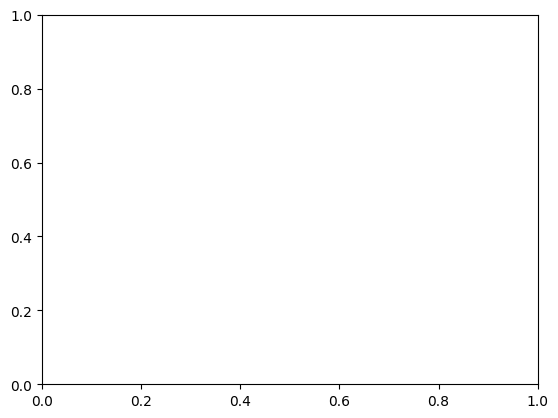

In [42]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
plot_tree(model, rankdir='LR')

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

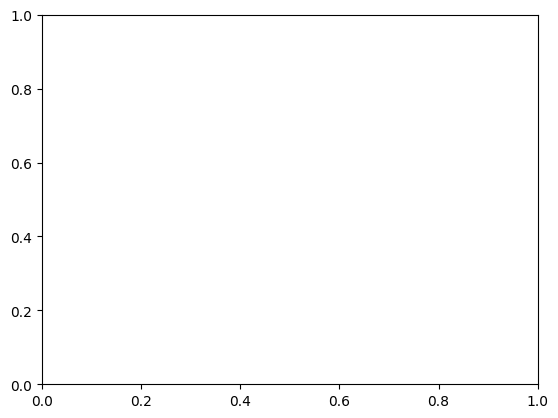

In [43]:
plot_tree(model, rankdir='LR', num_trees=1)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

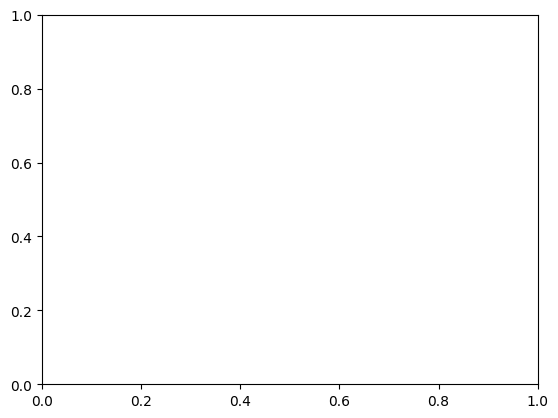

In [44]:
plot_tree(model, rankdir='LR', num_trees=15)

In [45]:
trees = model.get_booster().get_dump()

In [46]:
len(trees)

20

In [47]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.00448312238] yes=15,no=16,missing=16
				15:leaf=223.091629
				16:leaf=-263.189026
			8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.015822785] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.0117352316] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[CompetitionDistance<0.00276898732] yes=27,no=28,missing=28
				27:leaf=1261.60889
				28:leaf=752.9

In [48]:
#feature importance

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [49]:
importance_df.head(10)

,feature,importance
1,Promo,0.344243
12,DayOfWeek_1,0.078901
24,StoreType_b,0.074415
5,Promo2,0.050636
26,StoreType_d,0.044852
29,Assortment_c,0.041409
9,Month,0.032310
3,CompetitionDistance,0.032008
11,WeekOfYear,0.031260
23,StoreType_a,0.030250


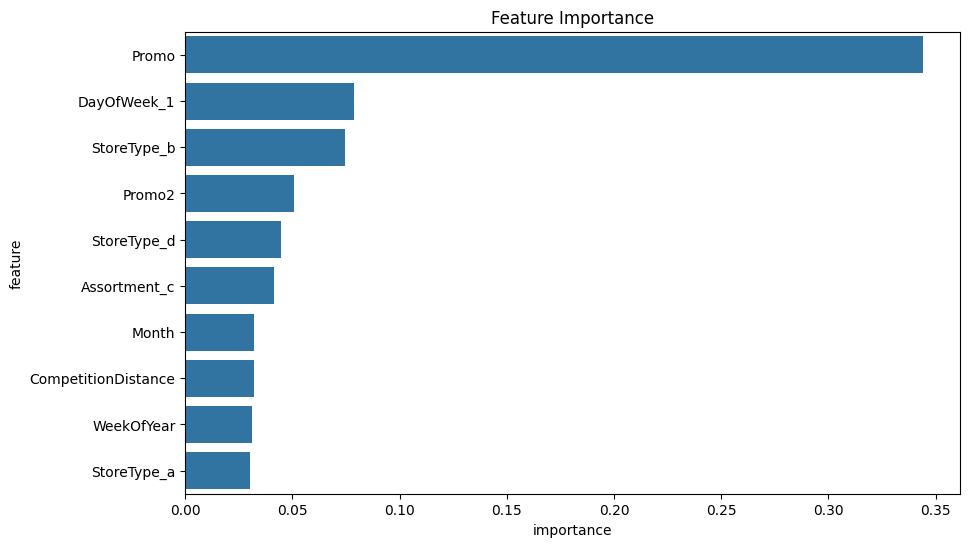

In [50]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [56]:
# K Fold Cross Validation
def train_and_evaluate(X_train, train_targets, X_val, val_targets, max_depth, n_estimators):
    # Create and train the model (example with XGBoost)
    model = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators)
    model.fit(X_train, train_targets)
    
    # Calculate train RMSE
    train_predictions = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(train_targets, train_predictions))
    
    # Calculate validation RMSE
    val_predictions = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
    
    return model, train_rmse, val_rmse


In [57]:
kfold = KFold(n_splits=5)

In [58]:
models = []  # Rename to avoid conflict
for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)  # Append to the list of models
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))


Train RMSE: 2394.8867245524934, Validation RMSE: 2462.8360496769883
Train RMSE: 2401.2406384878614, Validation RMSE: 2450.412210788476
Train RMSE: 2411.8926798093644, Validation RMSE: 2391.5910868526794
Train RMSE: 2347.002399625332, Validation RMSE: 2439.3327073738474
Train RMSE: 2397.846194846173, Validation RMSE: 2466.512201654716


In [66]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [67]:
preds = predict_avg(models, X)

In [68]:
preds

array([8057.5195, 7592.8687, 8729.01  , ..., 7434.3735, 7962.121 ,
       9660.862 ], dtype=float32)

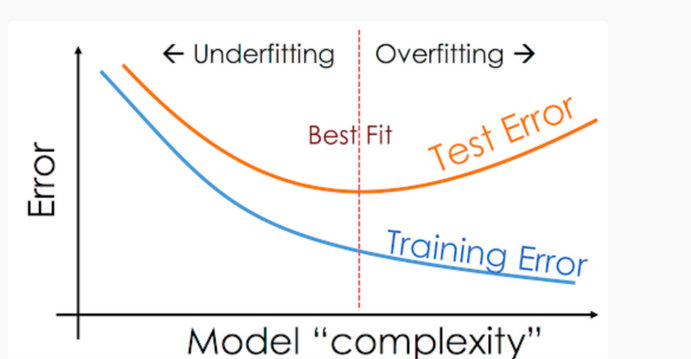

In [69]:
#Here's a helper function to test hyperparameters with K-fold cross validation.
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [73]:

def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

In [74]:
test_params(n_estimators=10)

Train RMSE: 2330.5525643069363, Validation RMSE: 2322.7258514039536


In [75]:
test_params(n_estimators=30)

Train RMSE: 1822.266685315214, Validation RMSE: 1835.7635397697277


In [76]:
test_params(n_estimators=100)

Train RMSE: 1155.8600832176949, Validation RMSE: 1179.5914195714558


In [77]:
test_params(n_estimators=240)

Train RMSE: 901.4685707426304, Validation RMSE: 939.9702601014419


In [78]:
test_params(max_depth=2)

Train RMSE: 2380.760311433324, Validation RMSE: 2378.2404328181988


In [79]:
test_params(max_depth=5)

Train RMSE: 1412.8852649070798, Validation RMSE: 1429.433592330221


In [80]:
test_params(max_depth=10)

Train RMSE: 671.7608686397843, Validation RMSE: 791.2118943067812


In [81]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 2790.267937519771, Validation RMSE: 2778.9356859856325


In [82]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2198.044079495805, Validation RMSE: 2202.247868265763


In [83]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 1515.3986419149267, Validation RMSE: 1534.0238850540752


In [84]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 1161.763419157803, Validation RMSE: 1185.534177326942


In [85]:
#Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using booster.

In [86]:
test_params(booster='gblinear')

Train RMSE: 2727.8679921465355, Validation RMSE: 2718.1235805414317


In [87]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [88]:
model.fit(X, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [89]:
test_preds = model.predict(X_test)

In [90]:
submission_df['Sales']  = test_preds

In [91]:
test_df.Open.isna().sum()

np.int64(11)

In [92]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [93]:
submission_df

,Id,Sales
0,1,4126.415039
1,2,7776.131836
2,3,9745.192383
3,4,8172.748535
4,5,7038.052246
...,...,...
41083,41084,2535.867920
41084,41085,7008.403809
41085,41086,6666.934082
41086,41087,23572.660156
